# Estimation of correlation between (centroid offset, position-angle offset) and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Sulyman Hossain, Ahmad Al - Imtiaz, S M Rafee Adnan, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the parameters (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"` , `"phi_light"`, `"phi_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (through our calculations using the Euclidean distance formula, or otherwise) to the values of light and mass centeroid offsets, and the position-angle offset, $\Delta\phi$. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the biweight midcorrelation ($r_{bicorr}$) between the centeroid (and the position-angle offsets) and the $\Sigma$ values. By sampling multiple times and calculating the biweight midcorrelations ($r_{bicorr}$) we get a population of $r_{bicorr}$ values and thus calculate its mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae for centroid offset


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Relevant formulae for position-angle offset

For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install 'git+https://github.com/ajshajib/paperfig.git'
!pip install 'git+https://github.com/ajshajib/coloripy.git'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ajshajib/paperfig.git to /tmp/pip-req-build-kx8fmbhx
  Running command git clone --filter=blob:none --quiet https://github.com/ajshajib/paperfig.git /tmp/pip-req-build-kx8fmbhx
  Resolved https://github.com/ajshajib/paperfig.git to commit 7a0d34b2a87a6a15a209aaa63c81278a8f3ef8b1
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ajshajib/coloripy.git to /tmp/pip-req-build-l6ehm_ci
  Running command git clone --filter=blob:none --quiet https://github.com/ajshajib/coloripy.git /tmp/pip-req-build-l6ehm_ci
  Resolved https://github.com/ajshajib/coloripy.git to commit 5afea47038ce557fde82d447c20c9f4ca50d34bb
  Preparing metadata (setup.py) ... done


In [3]:
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import yaml
from numpy.random import normal
from astropy.stats import biweight_midcorrelation
import coloripy as cp
import matplotlib as mpl
import paperfig as pf
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

## List of the model names

In [4]:
lens_names = [
    "DESIJ0132-1600",
    "DESIJ0136-0008",
    "DESIJ0201-2739",
    "DESIJ0215-2909",
    "DESIJ0618+5018",
    "DESIJ0923+1829",
    "DESIJ1018-0121",
    "DESIJ1101-0602",
    "DESIJ1205+4110",
    "DESIJ1501+5208",
    "DESIJ1537+1443",
    "DESIJ1554+0443",
    "DESIJ1624+0129",
    "DESIJ1709+3154",
    "DESIJ2158+0257",
]

## Estimate uncertainty in the Physical distance using Monte Carlo random sampling

In [5]:
# Define cosmological parameters
H0 = 70
Om0 = 0.3

# Define a function to estimate uncertainty in the Physical distance using Monte Carlo random sampling
def calculate_physical_distance_stats(z, z_uncertainty, angles_arcsec, angles_arcsec_uncertainty, num_samples=10000):
    
    # Generate random samples of redshift and angular distance using normal distribution
    z_samples = np.random.normal(z, z_uncertainty, num_samples)
    angles_arcsec_samples = np.random.normal(angles_arcsec, angles_arcsec_uncertainty, num_samples)
    
    # Define a function to calculate physical distance from redshift and angular distance
    def physical_distance(angles_arcsec, redshift):
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
        angular_diameter_distance = cosmo.angular_diameter_distance(redshift)

        angles_radian = np.radians(angles_arcsec / 3600)

        physical_distance = angular_diameter_distance * angles_radian
        physical_distance = physical_distance.to(u.kpc)

        return physical_distance.value
    
    # Calculate physical distances for each sampled redshift and angle
    physical_distances = physical_distance(angles_arcsec_samples, z_samples)
    
    # Calculate statistics in kiloparsec unit
    physical_distance_mean = np.mean(physical_distances)
    physical_distance_std = np.std(physical_distances)
    
    return physical_distance_mean, physical_distance_std

## Uncertainty propagation

In [6]:
# list for storing the Sigmas
Sigma_10a_dset = []
Sigma_10afs_dset = []
Sigma_10b_dset = []
Sigma_10bfs_dset = []
Sigma_10c_dset = []
Sigma_10cfs_dset = []
Sigma_10d_dset = []
Sigma_10dfs_dset = []

Sigma_20a_dset = []
Sigma_20afs_dset = []
Sigma_20b_dset = []
Sigma_20bfs_dset = []
Sigma_20c_dset = []
Sigma_20cfs_dset = []
Sigma_20d_dset = []
Sigma_20dfs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = (
    []
)  # uncertainty propagated standard deviation of the center offsets
dphis = []  # mean offsets between the light and mass position angle
sigma_dphis = (
    []
)  # uncertainty propagated standard deviation of the position angle offsets

theta_E_m = []  # Einstein radius
theta_E_u = []
gamma_shear_m = []  # shear
gamma_shear_u = []


for i in range(len(lens_names)):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue

    list_params = [
        "center_x_light",
        "center_x_mass",
        "center_y_light",
        "center_y_mass",
        
        "phi_mass",
        "phi_light",
        
        "gamma_shear",
        "theta_E",
        
        "Sigma_10a",
        "Sigma_10a_flux_selected",
        "Sigma_10b",
        "Sigma_10b_flux_selected",
        "Sigma_10c",
        "Sigma_10c_flux_selected",
        "Sigma_10d",
        "Sigma_10d_flux_selected",
        "Sigma_20a",
        "Sigma_20a_flux_selected",
        "Sigma_20b",
        "Sigma_20b_flux_selected",
        "Sigma_20c",
        "Sigma_20c_flux_selected",
        "Sigma_20d",
        "Sigma_20d_flux_selected",
        "z_phot"
    ]
    # parameters filtered by list params
    outputs = {k: data.get(k) for k in list_params}

    data_points.append(outputs)

    Sigma_10a_dset.append(data.get("Sigma_10a"))
    Sigma_10afs_dset.append(data.get("Sigma_10a_flux_selected"))
    Sigma_10b_dset.append(data.get("Sigma_10b"))
    Sigma_10bfs_dset.append(data.get("Sigma_10b_flux_selected"))
    Sigma_10c_dset.append(data.get("Sigma_10c"))
    Sigma_10cfs_dset.append(data.get("Sigma_10c_flux_selected"))
    Sigma_10d_dset.append(data.get("Sigma_10d"))
    Sigma_10dfs_dset.append(data.get("Sigma_10d_flux_selected"))
    
    
    
    Sigma_20a_dset.append(data.get("Sigma_20a"))
    Sigma_20afs_dset.append(data.get("Sigma_20a_flux_selected"))
    Sigma_20b_dset.append(data.get("Sigma_20b"))
    Sigma_20bfs_dset.append(data.get("Sigma_20b_flux_selected"))
    Sigma_20c_dset.append(data.get("Sigma_20c"))
    Sigma_20cfs_dset.append(data.get("Sigma_20c_flux_selected"))
    Sigma_20d_dset.append(data.get("Sigma_20d"))
    Sigma_20dfs_dset.append(data.get("Sigma_20d_flux_selected"))
    
    x_diff = abs(
        data_points[i]["center_x_light"][0] - data_points[i]["center_x_mass"][0]
    )
    y_diff = abs(
        data_points[i]["center_y_light"][0] - data_points[i]["center_y_mass"][0]
    )

    center_diff = (x_diff**2 + y_diff**2) ** 0.5

    sigma_x_light = mean(
        [data_points[i]["center_x_light"][1], data_points[i]["center_x_light"][2]]
    )
    sigma_x_mass = mean(
        [data_points[i]["center_x_mass"][1], data_points[i]["center_x_mass"][2]]
    )
    sigma_y_light = mean(
        [data_points[i]["center_y_light"][1], data_points[i]["center_y_light"][2]]
    )
    sigma_y_mass = mean(
        [data_points[i]["center_y_mass"][1], data_points[i]["center_y_mass"][2]]
    )

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2) ** 0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2) ** 0.5
    
    # Uncertainty in centroid offset in arcsecond
    sigma_center_diff = (
        ((x_diff / center_diff) ** 2) * sigma_x_diff**2
        + ((y_diff / center_diff) ** 2) * sigma_y_diff**2
    ) ** 0.5
    
    # Convert the angular distance to physical distance distribution and estimate uncertainty (in kpc)
    
    z = data_points[i]["z_phot"][0] # redshift
    z_uncertainty = data_points[i]["z_phot"][1] # redshift's uncertainty
    center_diff, sigma_center_diff = calculate_physical_distance_stats(z, z_uncertainty, center_diff, sigma_center_diff)
    #print(center_diff, sigma_center_diff)
    
    center_diffs.append(center_diff)
    sigma_center_diffs.append(sigma_center_diff)

    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphi = dphi * (180/np.pi)  # radians-to-degrees conversion
    dphis.append(dphi)

    sigma_phi_mass = mean(
        [data_points[i]["phi_mass"][1], data_points[i]["phi_mass"][2]]
    )
    sigma_phi_light = mean(
        [data_points[i]["phi_light"][1], data_points[i]["phi_light"][2]]
    )

    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2) ** 0.5
    sigma_dphi = sigma_dphi * (180/np.pi)  # radians-to-degrees conversion
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]
    data_points[i]["center_diff"] = [center_diff, sigma_center_diff, sigma_center_diff]
    
    centroid_offset_np = [center_diff, sigma_center_diff, sigma_center_diff]
    centroid_offset_float = [x.item() for x in centroid_offset_np]
    
    # Extracting Einstein Radius (in arcsecond unit)
    theta_E_median = data_points[i]["theta_E"][0]
    theta_E_uncertainty = (data_points[i]["theta_E"][1] + data_points[i]["theta_E"][2]) * 0.5
    
    # Convert the angular distance to physical distance distribution and estimate uncertainty (in kpc)
        
    z = data_points[i]["z_phot"][0] # redshift
    z_uncertainty = data_points[i]["z_phot"][1] # redshift's uncertainty
    theta_E_mean,  theta_E_std = calculate_physical_distance_stats(z, z_uncertainty, theta_E_median, theta_E_uncertainty)
    
    theta_E_m.append(theta_E_mean)
    theta_E_u.append(theta_E_std)
    
    data_points[i]["theta_E_kpc"] = [theta_E_mean, theta_E_std, theta_E_std]

    
     # Extracting Gamma Shear
    gamma_shear_m.append(data_points[i]["gamma_shear"][0])
    gamma_shear_u.append((data_points[i]["gamma_shear"][1] + data_points[i]["gamma_shear"][2]) * 0.5)

    # Add the centroid and position-angle offsets to the yaml files
    # Load existing YAML content if the file exists
    existing_content = {}
    data_to_append = {"centroid_offset": centroid_offset_float,
                      "position_angle_offset": [dphi, sigma_dphi, sigma_dphi],}

    try:
        with open(output_path, "r") as file:
            existing_content = yaml.safe_load(file)
    except FileNotFoundError:
        pass

    # Update the existing content with new variables
    existing_content.update(data_to_append)

    # Write the updated content back to the YAML file
    with open(output_path, "w") as file:
        yaml.dump(existing_content, file, default_flow_style=False)

In [7]:
print(Sigma_10a_dset)
print(Sigma_10afs_dset)
print(Sigma_20a_dset)
print(Sigma_20afs_dset)

[885.6844321574529, 844.4853537849862, 1502.3939572077081, 617.0278512634234, 1382.3660111220374, 669.8430828721096, 1707.6616174836408, 1520.9941936390326, 759.804648625035, 796.3102734897103, 778.9703208226316, 923.6375656198019, 1053.8640220687269, 333.878298055006, 1991.6167681642269]
[318.63787867102513, 251.32252764545498, 1464.0725721341971, 414.27386882250653, 285.67843233923566, 319.1891328757084, 493.5462902918702, 352.07520614386954, 725.6872687685428, 761.4598365384358, 452.75768796715556, 556.5689529537208, 777.6995326278923, 245.7327077084474, 1129.4030523657432]
[1020.1818782648606, 687.3855765017386, 1596.9016339482755, 743.5398056381829, 853.6927826725971, 546.9448802010445, 988.7087555304213, 1441.7044818356503, 725.7054369374023, 899.102698169801, 761.5631188516752, 1100.8637831301494, 1039.9086556572079, 382.6824211757463, 1667.6006580065996]
[298.53798273128245, 219.07592644381447, 1137.6703759394834, 348.05927127673493, 197.44923899012213, 394.7332186666142, 280.0

## Sampling and biweight midcorrelation ($r_{bicorr}$) calculation

### Function definition

In [8]:
# Function for sampling and calculating the pearson correlation coefficients between two parameters

def sample2_and_calc_r(param1, param2, size):
    """
    Sample and calculate biweight_midcorrelation between param1 and the param2, and return
    a list of the form [r_median, r_lower, r_upper]

    :param param1: parameter for normal distribution sampling
    :param param2: parameter for normal distribution sampling
    :param size: population size of the pearson-r samples
    :return: list; [r_median, r_upper, r_lower]
    """

    samples_r = []

    for i in range(size):
        p1 = []
        p2 = []

        for j in range(len(lens_names)):
            p1.append(
                normal(
                    data_points[j][param1][0],
                    (data_points[j][param1][1] + data_points[j][param1][2]) * 0.5,
                )
            )
            if isinstance(data_points[j][param2], list):
                p2.append(
                    normal(
                        data_points[j][param2][0],
                        (data_points[j][param2][1] + data_points[j][param2][2]) * 0.5,
                    )
                )
            else:
                p2.append(data_points[j][param2])

        samples_r.append(biweight_midcorrelation(np.array(p1), np.array(p2)))

    samples_r_arr = np.array(samples_r)
    r_median = np.median(samples_r_arr).item()
    r_lower = np.percentile(samples_r_arr, 16.0).item()
    r_upper = np.percentile(samples_r_arr, 84.0).item()

    return [r_median, r_upper, r_lower]

### Biweight midcorrelation ($r_{bicorr}$) calculation

In [9]:
size = 1000  # population size

# centoid offset cases
r_centroid_off_Sigma_10a = sample2_and_calc_r("center_diff", "Sigma_10a", size)
r_centroid_off_Sigma_10afs = sample2_and_calc_r(
    "center_diff", "Sigma_10a_flux_selected", size
)
r_centroid_off_Sigma_20a = sample2_and_calc_r("center_diff", "Sigma_20a", size)
r_centroid_off_Sigma_20afs = sample2_and_calc_r(
    "center_diff", "Sigma_20a_flux_selected", size
)

r_centroid_off_Sigma_10b = sample2_and_calc_r("center_diff", "Sigma_10b", size)
r_centroid_off_Sigma_10bfs = sample2_and_calc_r(
    "center_diff", "Sigma_10b_flux_selected", size
)
r_centroid_off_Sigma_20b = sample2_and_calc_r("center_diff", "Sigma_20b", size)
r_centroid_off_Sigma_20bfs = sample2_and_calc_r(
    "center_diff", "Sigma_20b_flux_selected", size
)

r_centroid_off_Sigma_10c = sample2_and_calc_r("center_diff", "Sigma_10b", size)
r_centroid_off_Sigma_10cfs = sample2_and_calc_r(
    "center_diff", "Sigma_10c_flux_selected", size
)
r_centroid_off_Sigma_20c = sample2_and_calc_r("center_diff", "Sigma_20c", size)
r_centroid_off_Sigma_20cfs = sample2_and_calc_r(
    "center_diff", "Sigma_20c_flux_selected", size
)

r_centroid_off_Sigma_10d = sample2_and_calc_r("center_diff", "Sigma_10d", size)
r_centroid_off_Sigma_10dfs = sample2_and_calc_r(
    "center_diff", "Sigma_10c_flux_selected", size
)
r_centroid_off_Sigma_20d = sample2_and_calc_r("center_diff", "Sigma_20d", size)
r_centroid_off_Sigma_20cfs = sample2_and_calc_r(
    "center_diff", "Sigma_20d_flux_selected", size
)

# position angle offset cases
r_dphi_Sigma_10a = sample2_and_calc_r("dphi", "Sigma_10a", size)
r_dphi_Sigma_10afs = sample2_and_calc_r("dphi", "Sigma_10a_flux_selected", size)
r_dphi_Sigma_20a = sample2_and_calc_r("dphi", "Sigma_20a", size)
r_dphi_Sigma_20afs = sample2_and_calc_r("dphi", "Sigma_20a_flux_selected", size)

r_dphi_Sigma_10b = sample2_and_calc_r("dphi", "Sigma_10b", size)
r_dphi_Sigma_10bfs = sample2_and_calc_r("dphi", "Sigma_10b_flux_selected", size)
r_dphi_Sigma_20b = sample2_and_calc_r("dphi", "Sigma_20b", size)
r_dphi_Sigma_20bfs = sample2_and_calc_r("dphi", "Sigma_20b_flux_selected", size)

r_dphi_Sigma_10c = sample2_and_calc_r("dphi", "Sigma_10c", size)
r_dphi_Sigma_10cfs = sample2_and_calc_r("dphi", "Sigma_10c_flux_selected", size)
r_dphi_Sigma_20c = sample2_and_calc_r("dphi", "Sigma_20c", size)
r_dphi_Sigma_20cfs = sample2_and_calc_r("dphi", "Sigma_20c_flux_selected", size)

r_dphi_Sigma_10d = sample2_and_calc_r("dphi", "Sigma_10d", size)
r_dphi_Sigma_10dfs = sample2_and_calc_r("dphi", "Sigma_10d_flux_selected", size)
r_dphi_Sigma_20d = sample2_and_calc_r("dphi", "Sigma_20d", size)
r_dphi_Sigma_20dfs = sample2_and_calc_r("dphi", "Sigma_20d_flux_selected", size)


# Einstein Radius, and Gamma Shear with Sigma_10 from Method A

r_theta_E_Sigma_10a = sample2_and_calc_r(
    "theta_E_kpc", "Sigma_10a", size
)

r_gamma_shear_Sigma_10a = sample2_and_calc_r("gamma_shear", "Sigma_10a", size)

## Error-bar plot

### Set the figure layout and typography

In [10]:
pf.set_fontscale(2.0)

# for MNRAS
mpl.rcParams["ps.fonttype"] = 42

# to change tex to Times New Roman in mpl
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"
plt.rcParams["mathtext.fontset"] = "custom"


sns.set(style="ticks", context="paper", font="Times New Roman", font_scale=2.0)
# sns.set_context('talk')
sns.set_style(
    {
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 2.0,
    }
)
# sns.set_palette('Set2')

cmap = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.6,
    dark=0.8,
    reverse=False,
    as_cmap=True,
)
cmap2 = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.2,
    dark=1.0,
    reverse=False,
    as_cmap=True,
)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale="power", power=2.5)

### Function definition

In [11]:
# Function for scatter ploting with error bars


def errbar_plot(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o--", color=c, alpha=0.5, capsize=5)

    str = f"$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:

        #Centroid Offset Method A
        case ["S_10a", "centroid_offset"]:
            ax.text(
            0.45,
            0.8,
            r"centroid offset vs. $\Sigma_{10A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10afs", "centroid_offset"]:
            ax.text(
            0.45,
            0.75,
            r"centroid offset vs. $\Sigma_{10A, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20a", "centroid_offset"]:
            ax.text(
            0.45,
            0.70,
            r"centroid offset vs. $\Sigma_{20A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20afs", "centroid_offset"]:
            ax.text(
            0.45,
            0.65,
            r"centroid offset vs. $\Sigma_{20A, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Position Angle Offset Method A
        case ["S_10a", "position_angle_offset"]:
            ax.text(
            0.45,
            0.8,
            r"position angle offset vs. $\Sigma_{10A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10afs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.75,
            r"position angle offset vs. $\Sigma_{10A, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20a", "position_angle_offset"]:
            ax.text(
            0.45,
            0.7,
            r"position angle offset vs. $\Sigma_{20A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20afs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.65,
            r"position angle offset vs. $\Sigma_{20A, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Centroid Offset Method B
        case ["S_10b", "centroid_offset"]:
            ax.text(
            0.45,
            0.75,
            r"centroid offset vs. $\Sigma_{10B}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10bfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.7,
            r"centroid offset vs. $\Sigma_{10B, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20b", "centroid_offset"]:
            ax.text(
            0.45,
            0.65,
            r"centroid offset vs. $\Sigma_{20B}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20bfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.6,
            r"centroid offset vs. $\Sigma_{20B, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Position Angle Offset Method B
        case ["S_10b", "position_angle_offset"]:
            ax.text(
            0.45,
            0.75,
            r"position angle offset vs. $\Sigma_{10B}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10bfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.7,
            r"position angle offset vs. $\Sigma_{10B, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20b", "position_angle_offset"]:
            ax.text(
            0.45,
            0.65,
            r"position angle offset vs. $\Sigma_{20B}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20bfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.6,
            r"position angle offset vs. $\Sigma_{20B, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        #Centroid Offset Method C
        case ["S_10c", "centroid_offset"]:
            ax.text(
            0.45,
            0.7,
            r"centroid offset vs. $\Sigma_{10C}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10cfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.65,
            r"centroid offset vs. $\Sigma_{10C, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20c", "centroid_offset"]:
            ax.text(
            0.45,
            0.6,
            r"centroid offset vs. $\Sigma_{20C}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20cfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.55,
            r"centroid offset vs. $\Sigma_{20C, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Position Angle Offset Method C
        case ["S_10c", "position_angle_offset"]:
            ax.text(
            0.45,
            0.7,
            r"position angle offset vs. $\Sigma_{10C}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10cfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.65,
            r"position angle offset vs. $\Sigma_{10C, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20c", "position_angle_offset"]:
            ax.text(
            0.45,
            0.6,
            r"position angle offset vs. $\Sigma_{20C}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20cfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.55,
            r"position angle offset vs. $\Sigma_{20C, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Centroid Offset Method D
        case ["S_10d", "centroid_offset"]:
            ax.text(
            0.45,
            0.65,
            r"centroid offset vs. $\Sigma_{10D}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10dfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.60,
            r"centroid offset vs. $\Sigma_{10D, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20d", "centroid_offset"]:
            ax.text(
            0.45,
            0.55,
            r"centroid offset vs. $\Sigma_{20D}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20dfs", "centroid_offset"]:
            ax.text(
            0.45,
            0.5,
            r"centroid offset vs. $\Sigma_{20D, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        #Position Angle Offset Method D
        case ["S_10d", "position_angle_offset"]:
            ax.text(
            0.45,
            0.65,
            r"position angle offset vs. $\Sigma_{10D}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_10dfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.60,
            r"position angle offset vs. $\Sigma_{10D, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20d", "position_angle_offset"]:
            ax.text(
            0.45,
            0.55,
            r"position angle offset vs. $\Sigma_{20D}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)

        case ["S_20dfs", "position_angle_offset"]:
            ax.text(
            0.45,
            0.5,
            r"position angle offset vs. $\Sigma_{20D, \rm flux\ selected}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
        
        # For theta_E vs Sigma_10A and Gamma_shear vs Sigma_10A
        case ["S_10a", "theta_E_kpc"]:
            ax.text(
            0.75,
            0.95,
            r"$\theta_{E}$ vs. $\Sigma_{10A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
            
        case ["S_10a", "gamma_shear"]:
            ax.text(
            0.75,
            0.95,
            r"$\gamma_{\rm shear}$ vs. $\Sigma_{10A}$): " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
            
            
            
    ax.tick_params(direction="in")

In [12]:
## METHOD A_10
zipped = zip(Sigma_10a_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10a_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD A_10_FS
zipped = zip(Sigma_10afs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10afs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD A_20
zipped = zip(Sigma_20a_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20a_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD A_20_FS
zipped = zip(Sigma_20afs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20afs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD B_10
zipped = zip(Sigma_10b_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10b_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

#METHOD B_10_FS
zipped = zip(Sigma_10bfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10bfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD B_20
zipped = zip(Sigma_20b_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20b_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD B_20_FS
zipped = zip(Sigma_20bfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20bfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

#METHOD C_10
zipped = zip(Sigma_10c_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10c_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

#METHOD C_10_FS
zipped = zip(Sigma_10cfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10cfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD C_20
zipped = zip(Sigma_20c_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20c_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD C_20_FS
zipped = zip(Sigma_20cfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20cfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

#METHOD D_10
zipped = zip(Sigma_10d_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10d_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

#METHOD D_10_FS
zipped = zip(Sigma_10dfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_10dfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD D_20
zipped = zip(Sigma_20d_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20d_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

## METHOD D_20_FS
zipped = zip(Sigma_20dfs_dset, center_diffs, sigma_center_diffs)

# Converting to list
zipped = list(zipped)

# Printing zipped list
#print("Initial zipped list - ", str(zipped))

# Using sorted and lambda
res = sorted(zipped, key = lambda x: x[0])

# printing result
#print("final list - ", str(res))

ls = [list(t) for t in zip(*res)]

Sigma_20dfs_dset = ls[0]
center_diffs = ls[1]
sigma_center_diffs = ls[2]

# Centroid offset vs.  $\Sigma$ cases

## Centroid offset vs. Sigma_10 from Method A

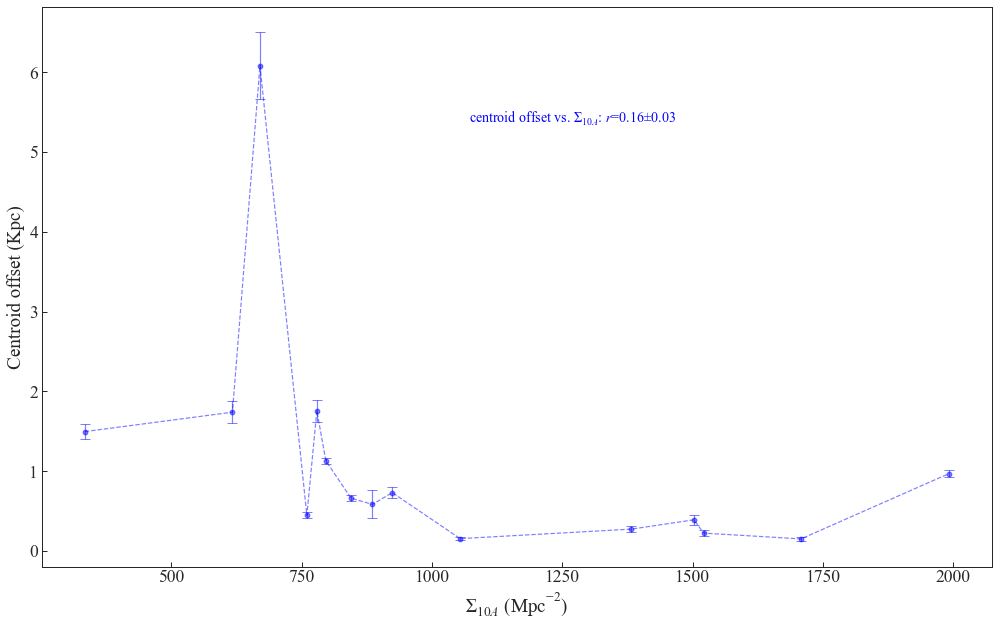

In [13]:
#fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_colwidth * 2))
fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))
errbar_plot(
    Sigma_10a_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10a", "centroid_offset"],
    r_centroid_off_Sigma_10a,
    ax,
    "blue",
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (Kpc)")
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10A.pdf", bbox_inches="tight")

## Centroid offset vs. (Sigma_10 from Method A to D).

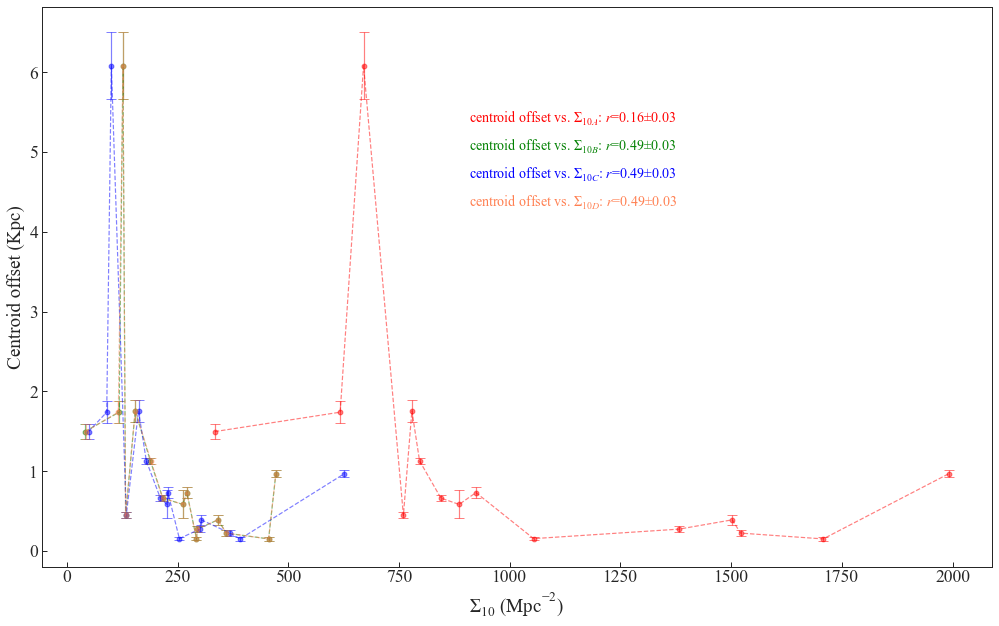

In [14]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10a", "centroid_offset"],
    r_centroid_off_Sigma_10a,
    ax,
    "red"
)
errbar_plot(
    Sigma_10b_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10b", "centroid_offset"],
    r_centroid_off_Sigma_10b,
    ax,
    "green"
)
errbar_plot(
    Sigma_10c_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10c", "centroid_offset"],
    r_centroid_off_Sigma_10c,
    ax,
    "blue"
)
errbar_plot(
    Sigma_10d_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10d", "centroid_offset"],
    r_centroid_off_Sigma_10d,
    ax,
    "coral"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (Kpc)")
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight")


## Centroid offset vs. Sigmas from Method A

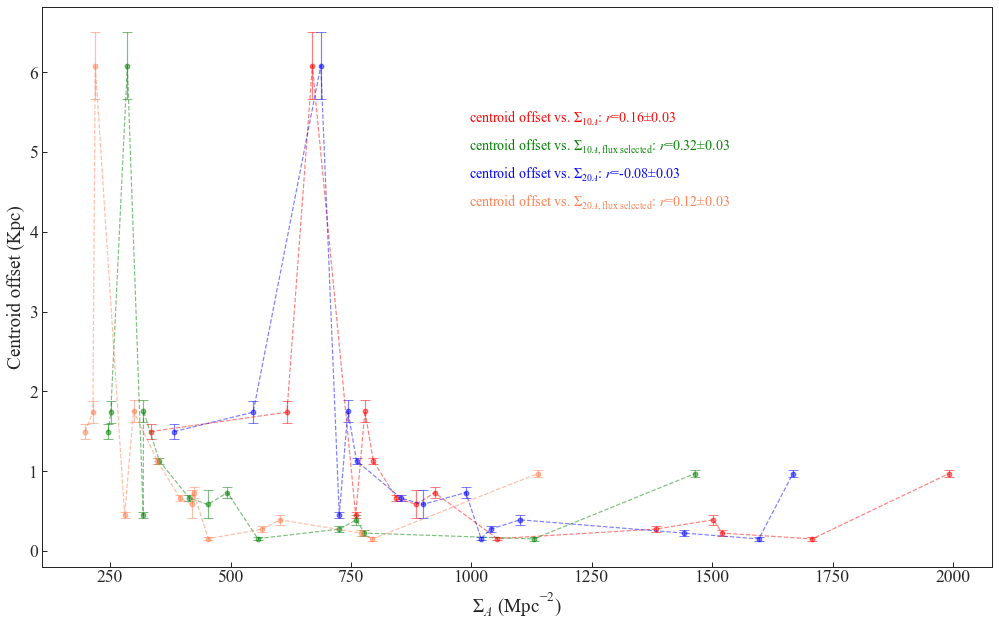

In [15]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10a", "centroid_offset"],
    r_centroid_off_Sigma_10a,
    ax,
    "red"
)
errbar_plot(
    Sigma_10afs_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10afs", "centroid_offset"],
    r_centroid_off_Sigma_10afs,
    ax,
    "green"
)
errbar_plot(
    Sigma_20a_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_20a", "centroid_offset"],
    r_centroid_off_Sigma_20a,
    ax,
    "blue"
)
errbar_plot(
    Sigma_20afs_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_20afs", "centroid_offset"],
    r_centroid_off_Sigma_20afs,
    ax,
    "coral"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{A}$ (Mpc$^{-2})$")
plt.ylabel("Centroid offset (Kpc)")
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")


# Position-angle offset vs. $\Sigma$ cases

## Position-angle offset vs. Sigma_10 from Method A

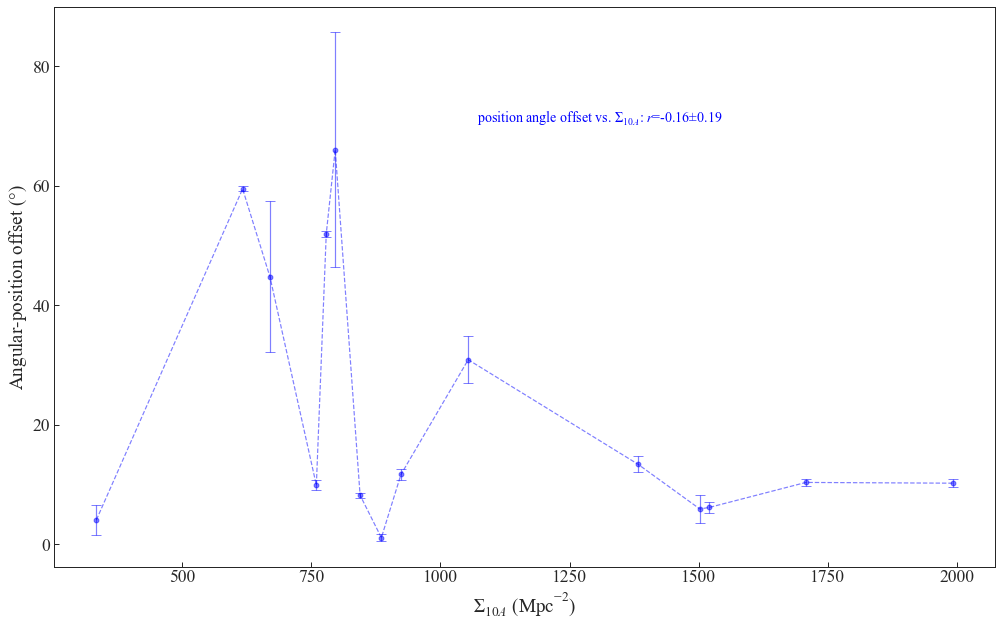

In [16]:
fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

errbar_plot(
    Sigma_10a_dset,
    dphis,
    sigma_dphis,
    ["S_10a", "position_angle_offset"],
    r_dphi_Sigma_10a,
    ax,
    "blue"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (Mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "../paper/figures/position_angle_offset_vs_Sigma_10A.pdf", bbox_inches="tight"
)

## Position-angle offset vs. (Sigma_10 from Method A to D)

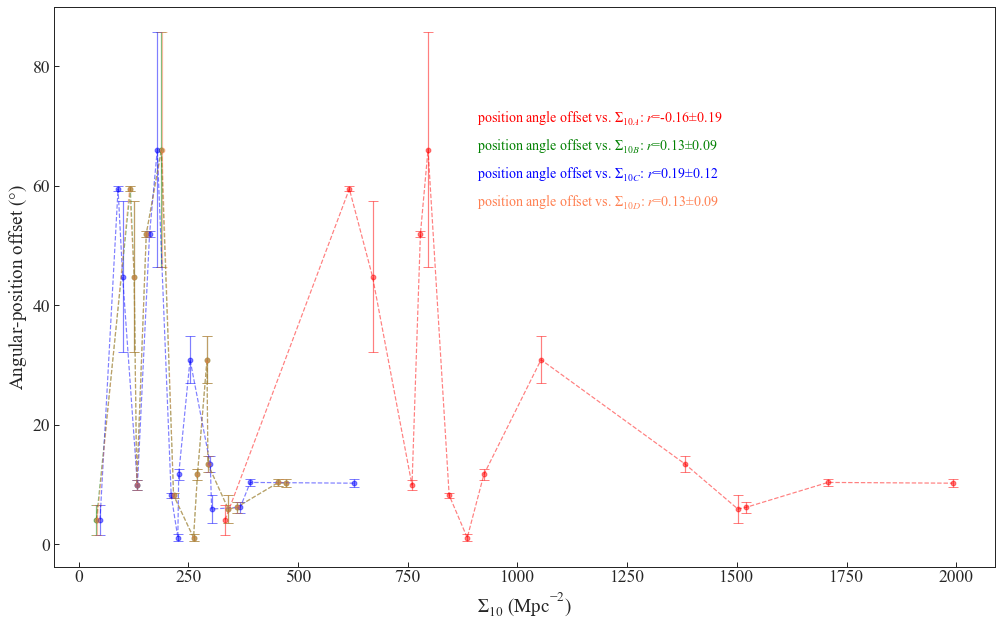

In [17]:
fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_dset,
    dphis,
    sigma_dphis,
    ["S_10a", "position_angle_offset"],
    r_dphi_Sigma_10a,
    ax,
    "red"
)
errbar_plot(
    Sigma_10b_dset,
    dphis,
    sigma_dphis,
    ["S_10b", "position_angle_offset"],
    r_dphi_Sigma_10b,
    ax,
    "green"
)
errbar_plot(
    Sigma_10c_dset,
    dphis,
    sigma_dphis,
    ["S_10c", "position_angle_offset"],
    r_dphi_Sigma_10c,
    ax,
    "blue"
)
errbar_plot(
    Sigma_10d_dset,
    dphis,
    sigma_dphis,
    ["S_10d", "position_angle_offset"],
    r_dphi_Sigma_10d,
    ax,
    "coral"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (Mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "../paper/figures/position_angle_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight"
)

## Position-angle offset vs. Sigmas from Method A


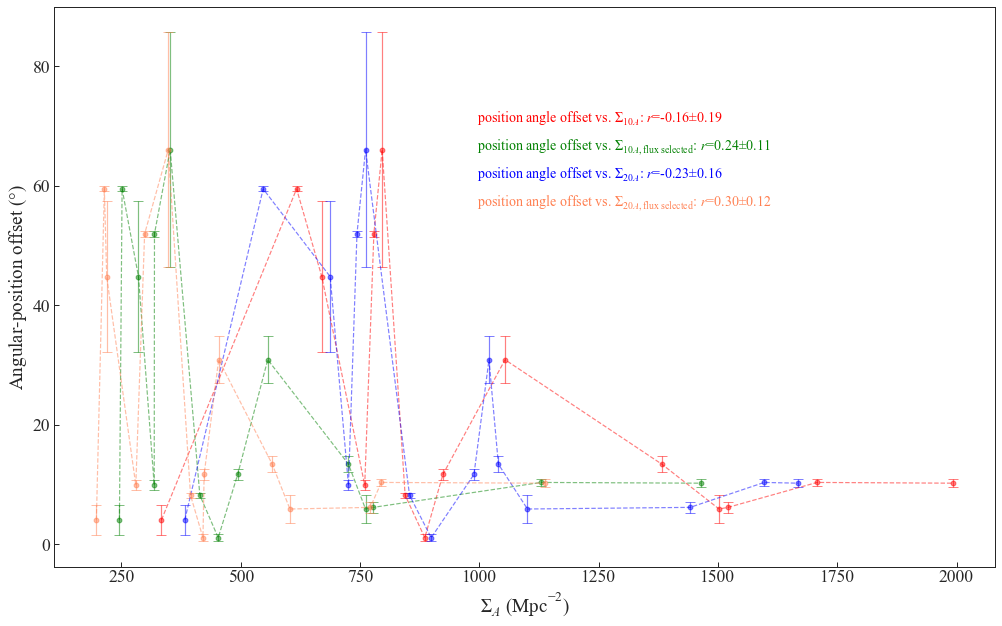

In [18]:
# plot for all the four cases of position angle offset vs. Sigmas

fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_dset,
    dphis,
    sigma_dphis,
    ["S_10a", "position_angle_offset"],
    r_dphi_Sigma_10a,
    ax,
    "red"
)
errbar_plot(
    Sigma_10afs_dset,
    dphis,
    sigma_dphis,
    ["S_10afs", "position_angle_offset"],
    r_dphi_Sigma_10afs,
    ax,
    "green"
)
errbar_plot(
    Sigma_20a_dset,
    dphis,
    sigma_dphis,
    ["S_20a", "position_angle_offset"],
    r_dphi_Sigma_20a,
    ax,
    "blue"
)
errbar_plot(
    Sigma_20afs_dset,
    dphis,
    sigma_dphis,
    ["S_20afs", "position_angle_offset"],
    r_dphi_Sigma_20afs,
    ax,
    "coral"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{A}$ (Mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "../paper/figures/position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight"
)

## Function without connecting points

In [19]:
# Function for sampling and calculating the pearson correlation coefficients between two parameters

def errbar_plot_disconnected(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o", color=c, alpha=0.5, capsize=5)

    str = f"$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:
 # For theta_E vs Sigma_10A and Gamma_shear vs Sigma_10A
        case ["S_10a", "theta_E_kpc"]:
            ax.text(
            0.75,
            0.95,
            r"$\theta_{E}$ vs. $\Sigma_{10A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
            
        case ["S_10a", "gamma_shear"]:
            ax.text(
            0.75,
            0.95,
            r"$\gamma_{\rm shear}$ vs. $\Sigma_{10A}$: " + str,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=14,
            color=c,)
            
            
    ax.tick_params(direction="in")

## Einstein Radius vs. Sigma_10 from Method A

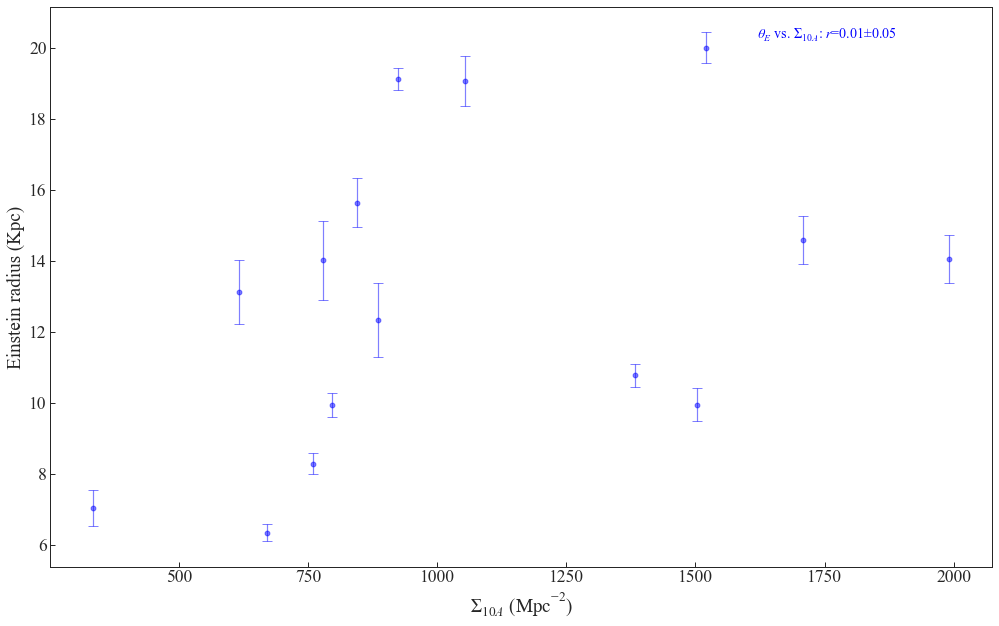

In [20]:
fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

errbar_plot_disconnected(
    Sigma_10a_dset,
    theta_E_m,
    theta_E_u,
    ["S_10a", "theta_E_kpc"],
    r_theta_E_Sigma_10a,
    ax,
    "blue"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (Mpc$^{-2})$")
plt.ylabel("Einstein radius (Kpc)")
plt.show()
fig.savefig(
    "../paper/figures/einstein_radius_vs_Sigma_10A.pdf", bbox_inches="tight"
)

## Gamma Shear vs. Sigma_10 from Method A

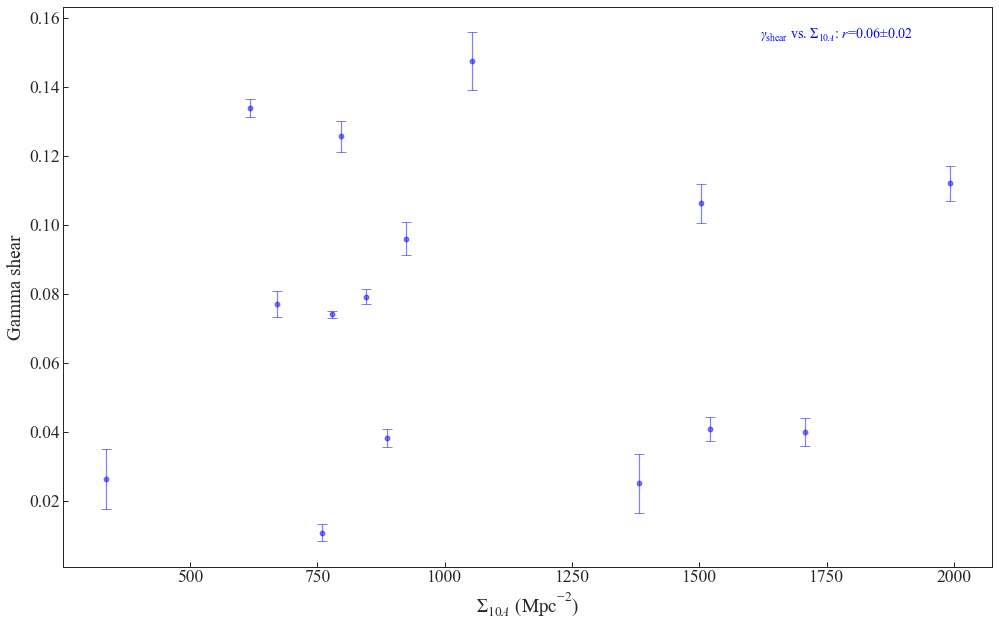

In [21]:
fig, ax = plt.subplots(1, 1,
                       figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

errbar_plot_disconnected(
    Sigma_10a_dset,
    gamma_shear_m,
    gamma_shear_u,
    ["S_10a", "gamma_shear"],
    r_gamma_shear_Sigma_10a,
    ax,
    "blue"
)

fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (Mpc$^{-2})$")
plt.ylabel("Gamma shear")
plt.show()
fig.savefig(
    "../paper/figures/gamma_shear_vs_Sigma_10A.pdf", bbox_inches="tight"
)